In [0]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [0]:
import re

In [3]:
%cd /content/drive/My Drive/data/av_sentiment

/content/drive/My Drive/data/av_sentiment


In [0]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [0]:
test['label']=0
train1 = pd.concat([train,test],axis=0)

In [6]:
train1.shape

(9873, 3)

In [7]:
train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


PreProcessing
1. Remove URLS
2. remove Hast tags

In [0]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_hash(text):
    return re.sub(r"#(\w+)",r"\1",text)

In [9]:
remove_hash("this is so #great")

'this is so great'

In [0]:
train.tweet = train.tweet.apply(remove_urls)
train.tweet = train.tweet.apply(remove_hash)

train1.tweet = train.tweet.apply(remove_urls)
train1.tweet = train.tweet.apply(remove_hash)

test.tweet = test.tweet.apply(remove_urls)
test.tweet = test.tweet.apply(remove_hash)



Prepare for Fastai 
1. language model
2. classfier with ulmfit

In [11]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = train1, valid_df = train, path = ".",test_df=test, text_cols='tweet',label_cols='label')

In [12]:
data_clas = TextClasDataBunch.from_df(path = "", train_df = train, valid_df = train,test_df=test, vocab=data_lm.train_ds.vocab, bs=32,text_cols='tweet', label_cols='label')

Create Language Model

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [14]:
#find learning rate
#lr_find records learning rate, and we have to find the point where is started to decrease fast
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


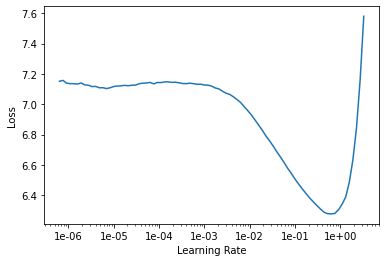

In [15]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(1, 1e-1,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.119096,3.929201,0.334375,00:27


In [17]:
learn.fit_one_cycle(1, 1e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.898558,3.601048,0.367520,00:27


In [0]:
learn.unfreeze()

In [19]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.632691,3.467787,0.381408,00:28
1,3.520858,3.235274,0.412435,00:28
2,3.322304,2.920638,0.458509,00:28
3,3.073393,2.613521,0.508983,00:28
4,2.798228,2.341049,0.552994,00:28
5,2.578596,2.149781,0.586787,00:28
6,2.347985,1.995051,0.614874,00:28
7,2.197000,1.908444,0.629448,00:28
8,2.101274,1.874077,0.636509,00:28
9,2.020779,1.866850,0.637663,00:28


In [0]:
learn.save("learn_finetuned")
learn.save_encoder("learn_finetuned_enc")

In [21]:
learn = text_classifier_learner(data_clas,AWD_LSTM, drop_mult=0.5)
learn.load_encoder('learn_finetuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (7920 items)
x: TextList
xxbos fingerprint xxmaj pregnancy xxmaj test android apps beautiful cute health igers iphoneonly iphonesia iphone,xxbos xxmaj finally a transparant silicon case ^^ xxmaj thanks to my uncle :) yay xxmaj sony xxmaj xperia s sonyexperias …,xxbos xxmaj we love this ! xxmaj would you go ? talk makememories unplug relax iphone smartphone wifi connect ...,xxbos i 'm wired i know i 'm xxmaj george i was made that way ;) iphone cute daventry home,xxbos xxmaj what amazing service ! xxmaj apple wo n't even talk to me about a question i have unless i pay them $ 19.95 for their stupid support !
y: CategoryList
0,0,0,0,1
Path: .;

Valid: LabelList (7920 items)
x: TextList
xxbos fingerprint xxmaj pregnancy xxmaj test android apps beautiful cute health igers iphoneonly iphonesia iphone,xxbos xxmaj finally a transparant silicon case ^^ xxmaj thanks to my uncle :) yay xxmaj sony xxmaj xperia s sonyexperias …,xxbos xxmaj we lov

In [22]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


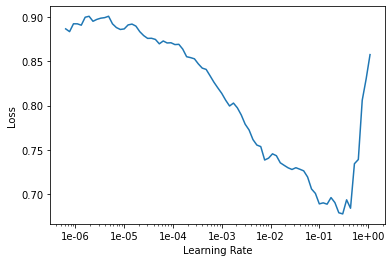

In [23]:
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.417005,0.358875,0.884848,00:35


In [26]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.303401,0.220561,0.909217,00:34


In [27]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.297558,0.190729,0.922601,00:35


In [28]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.235708,0.169773,0.932071,00:37
1,0.222817,0.142552,0.951389,00:34
2,0.204622,0.116952,0.967551,00:36
3,0.179133,0.087342,0.971717,00:35
4,0.161856,0.085793,0.973359,00:37


In [0]:
test['label']=0
for i in range(test.shape[0]):
  test.loc[i,'label'] = learn.predict(test.loc[i,'tweet'])[0]

In [0]:
test[['id','label']].to_csv("base_ulmfit.csv",index=False)

In [0]:
# train['labelp']=0
# for i in range(train.shape[0]):
#   train.loc[i,'labelp'] = learn.predict(train.loc[i,'tweet'])[0]